# Прикладные задачи анализа данных. Семинар 2. GAN

## 1. GAN.

GAN (Generative Adversarial Network) - семейство моделей, которые выучивают распределение над данными соревнованием (adversarial=состязание) двух нейронных сетей:

1. Дискриминатор пытается отличить сгенерированные объекты от реальных.
2. Генератор пытается обмануть дискриминатор и сгенерировать такие объекты, которые он не сможет отличить от настоящих.

Задача, которую решают сети, является минимаксной (одна сеть пытается минимизировать функционал, а другая максимизировать) и её точка равновесия достигается, когда генератор выдает объекты, полностью не отличимые от настоящих.


In [ ]:
from typing import Optional
import numpy as np

import torch
from torch import nn
from torch import optim
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

#device = 'cuda:0'
#torch.cuda.set_device(0)

device = ""
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# 1.1 GAN на 2d данных.

Давайте попробуем написать простые генератор и дискриминатор для генерации точек из 2d распределения.

In [ ]:
from sklearn import datasets

s_x, s_y = datasets.make_s_curve(n_samples=10000, noise=0.01)
s_x = s_x[:, [0, 2]]

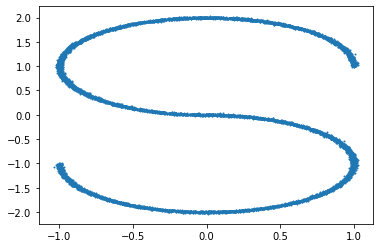

In [ ]:
plt.scatter(s_x[:, 0], s_x[:, 1], s=1)

In [ ]:
s_x

array([[-0.22584185,  1.98608347],
       [ 0.43232416,  1.91042245],
       [-0.96624589,  0.76627353],
       ...,
       [-0.01184792,  1.99592607],
       [-0.80921389,  1.59001265],
       [ 0.19378419, -0.02199161]])

In [ ]:
class Dataset2d:
  def __init__(self, x, y):
    self.x = x
    self.y = y
  
  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

  def __len__(self):
    return self.x.shape[0]

In [ ]:
tr_dataloader_2d = torch.utils.data.DataLoader(
    Dataset2d(torch.tensor(s_x, dtype=torch.float32), 
              torch.tensor(s_y)),
              batch_size=64, shuffle=True, num_workers=1)

In [ ]:
class Generator2d(nn.Module):
  def __init__(self, lat_size):
    super(Generator2d, self).__init__()
    self.lat_size = lat_size

    self.net = nn.Sequential(
        nn.Linear(self.lat_size, 16), nn.ReLU(),
        nn.Linear(16, 32), nn.ReLU(), 
        nn.Linear(32, 64), nn.ReLU(), 
        nn.Linear(64, 2))

  def forward(self, z):
    return self.net(z)
    

class Discriminator2d(nn.Module):
  def __init__(self):
    super(Discriminator2d, self).__init__()

    self.net = nn.Sequential(
        nn.Linear(2, 256), nn.ReLU(), nn.Dropout(0.3),
        nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.3),
        nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.3),
        nn.Linear(64, 1), nn.Sigmoid())

  def forward(self, x):
    return self.net(x)

## 2. Vanilla GAN.

Для Vanilla GAN функционал имеет следующий вид:

$L(D, G) = - \frac1n \sum_{x_i \in X} \log D(x_i) - \frac1n \sum_{z_i \in N(0, 1)} \log (1 - D(G(z_i))) \rightarrow \min_{D} \max_{G}$

На практике, дискриминатор и генератор обучают не одновременно, а чередуют $n$ шагов оптимизации _только_ генератора и $m$ шагов оптимизации _только_ дискриминатора. При этом, эмпирически получается лучше, когда дискриминатор обучается больше шагов, чем генератор. $n$ и $m$ являются гиперпараметрами и подбираются под задачу архитектуры генератора и дискриминатора.

Процесс обучения GAN'а можно описать следующим кодом.

In [ ]:
def train_gan(tr_dataloader,
              gen, discr, 
              gen_opt, discr_opt, prior, 
              num_epochs, gen_steps, discr_steps,
              discr_params_clip_value=None,
              verbose_num_iters=100,
              data_type='2d'):
    '''
    Имплементирует подсчет лосса для генератора и дискриминатора.
    '''
    loss_func = nn.BCELoss()
    #gen.train()
    #discr.train()
    gen_loss_trace = []
    discr_loss_trace = []

    iter_i = 0

    for epoch_i in range(num_epochs):        
        print(f'Epoch {epoch_i + 1}')
        for batch in tr_dataloader:
            # батч реальных объектов
            real_samples, _ = batch
            real_samples = real_samples.to(device)
            batch_size = real_samples.shape[0]

            # таргеты реальных объектов (1) и сгенерированных (0)
            real_samples_labels = torch.ones((batch_size, 1)).to(device)
            gen_samples_labels = torch.zeros((batch_size, 1)).to(device)
            lat_samples_codes = prior.sample((batch_size, ))

            # батч сгенерированных объектов
            gen_samples = gen(lat_samples_codes)

            # двойной батч на вход дискриминатору и его реальные таргеты (1 и 0)
            all_samples = torch.cat((real_samples, gen_samples), dim=0)
            all_samples_labels = torch.cat((real_samples_labels, gen_samples_labels), dim=0)

            # выходы дискриминатора на двойном батче
            all_samples_output = discr(all_samples)
            real_samples_output, gen_samples_output = torch.split(all_samples_output, batch_size)

            if (iter_i % (gen_steps + discr_steps)) < gen_steps:
                # генератор учится на gen_samples_output и считает ошибку по real_samples_labels
                gen_opt.zero_grad()
                gen_loss = loss_func(gen_samples_output, real_samples_labels)
                gen_loss.backward()
                gen_opt.step()
                gen_loss_trace.append((iter_i, gen_loss.item()))
            else:
                # дискриминатор учится на all_samples и считает ошибку по all_samples_labels = real_samples_labels + generated_samples_labels
                discr_opt.zero_grad()
                discr_loss = loss_func(all_samples_output, all_samples_labels)
                discr_loss.backward()
                discr_opt.step()
                discr_loss_trace.append((iter_i, discr_loss.item()))
        
            iter_i += 1
         # Выводим значения функций потерь
            if iter_i % verbose_num_iters == 0:
                clear_output(wait=True)
                plt.figure(figsize=(10, 5))
                
                plt.subplot(1, 3, 1)
                plt.xlabel('Iteration')
                plt.ylabel('Generator loss')
                plt.plot([p[0] for p in gen_loss_trace], 
                         [p[1] for p in gen_loss_trace])

                plt.subplot(1, 3, 2)
                plt.xlabel('Iteration')
                plt.ylabel('Discriminator loss')
                plt.plot([p[0] for p in discr_loss_trace], 
                         [p[1] for p in discr_loss_trace], color='orange')
                    
                if data_type == '2d':
                  plt.subplot(1, 3, 3)
                  with torch.no_grad():
                    z = prior.sample((1024, ))
                    sampled_2d = gen(z)
                  plt.scatter(
                    sampled_2d[:, 0].cpu().detach().numpy(),
                    sampled_2d[:, 1].cpu().detach().numpy(),
                    s=1)
                elif data_type == 'mnist':
                  with torch.no_grad():
                    z = prior.sample((100, ))
                    sampled_mnist = gen(z)

                  for i in range(16):
                    plt.subplot(4, 12, 12 * (i // 4) + 9 + (i % 4))
                    plt.axis('off')
                    plt.imshow(sampled_mnist[i].detach().cpu().reshape(32, 32), cmap="gray_r")

                plt.show()

Теперь давайте обучим GAN

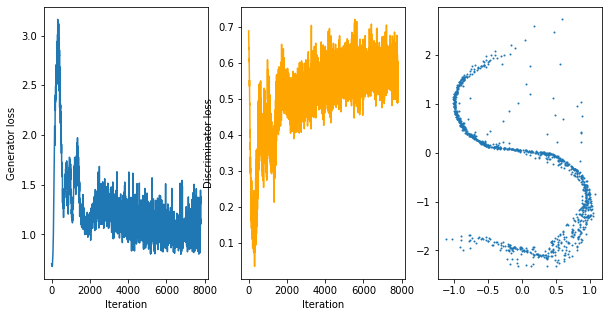

In [ ]:
# обучим наш GAN

gen_2d = Generator2d(2).to(device)
discr_2d = Discriminator2d().to(device)
prior_2d = torch.distributions.Normal(torch.zeros(2).cuda(), torch.ones(2).to(device))

gen_opt_2d = optim.Adam(gen_2d.parameters(), lr=3e-4)
discr_opt_2d = optim.Adam(discr_2d.parameters(), lr=3e-4, betas=(0.9, 0.999))

train_gan(tr_dataloader_2d, gen_2d, discr_2d, gen_opt_2d, discr_opt_2d,
          prior_2d, num_epochs=50, gen_steps=1, discr_steps=2, 
          verbose_num_iters=100)

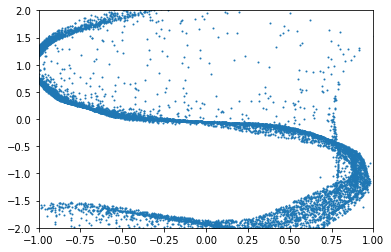

In [ ]:
# визуализируем получившееся распределение

z = prior_2d.sample((10000, ))

sampled_2d = gen_2d(z)

plt.xlim(-1, 1)
plt.ylim(-2, 2)

plt.scatter(sampled_2d[:, 0].cpu().detach().numpy(),
            sampled_2d[:, 1].cpu().detach().numpy(),
            s=1)

2d данные отлично подходят и для демонстрации слабых мест GAN'ов - когда данные состоят из нескольких мод (кластеров), ганы подверждены двум сценариям:
1. Mode collapse - ситуация, когда GAN игнорирует часть кластеров и не пытается их выучить.
2. Смешение мод - когда GAN соединяется две моды перешейком. Этот случай, как правило, решается взятием более мощного дискриминатора и генератора.

In [ ]:
circle_x, circle_y = datasets.make_circles(n_samples=10000, noise=0.01)

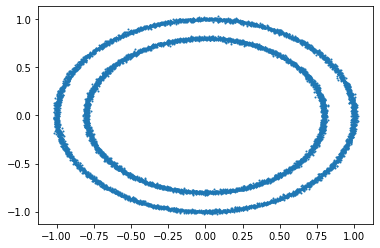

In [ ]:
plt.scatter(circle_x[:, 0], circle_x[:, 1], s=1)

In [ ]:
tr_dataloader_circle = torch.utils.data.DataLoader(
    Dataset2d(torch.tensor(circle_x, dtype=torch.float32), 
              torch.tensor(circle_y)),
              batch_size=64, shuffle=True, num_workers=1)


gen_2d = Generator2d(2).to(device)
discr_2d = Discriminator2d().to(device)
prior_2d = torch.distributions.Normal(torch.zeros(2).cuda(), torch.ones(2).to(device))

gen_opt_2d = optim.Adam(gen_2d.parameters(), lr=3e-4)
discr_opt_2d = optim.Adam(discr_2d.parameters(), lr=3e-4, betas=(0.9, 0.999))

train_gan(tr_dataloader_circle, gen_2d, discr_2d, gen_opt_2d, discr_opt_2d,
          prior_2d, num_epochs=30, gen_steps=1, discr_steps=1, 
          verbose_num_iters=100)

KeyboardInterrupt: ignored

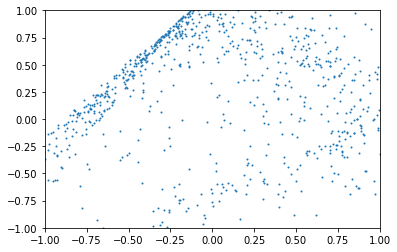

In [ ]:
z = prior_2d.sample((1024, ))

sampled_circle = gen_2d(z)

plt.xlim(-1, 1)
plt.ylim(-1, 1)

plt.scatter(sampled_circle[:, 0].cpu().detach().numpy(),
            sampled_circle[:, 1].cpu().detach().numpy(),
            s=1)

Выучилась только одна мода!

### 2.2 GAN на картинках.

Теперь давайте попробуем обучить GAN на данных посложнее - на картинках из датасета MNIST.

In [ ]:
from torchvision.datasets import MNIST

transform = transforms.Compose([
                transforms.Resize(32),
                transforms.ToTensor(),
                transforms.Normalize((0.5,),(0.5,))
                ])
trainset = MNIST(root='./data/', train=True, download=True, transform=transform)
trainloader_mnist = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

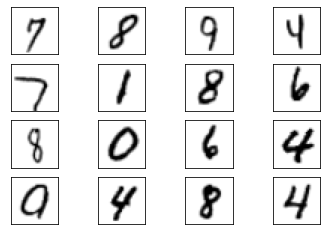

In [ ]:
real_samples, mnist_labels = next(iter(trainloader_mnist))
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(real_samples[i].reshape(32, 32), cmap="gray_r")
    plt.xticks([])
    plt.yticks([])

In [ ]:
class GeneratorMNIST(nn.Module):
    def __init__(self, lat_size, hidden=64):
        super(GeneratorMNIST, self).__init__()
        self.lat_size = lat_size
        
        self.net = nn.Sequential(
            nn.Linear(100, 256),  nn.ReLU(),
            nn.Linear(256, 512),  nn.ReLU(),
            nn.Linear(512, 1024), nn.ReLU(),
            nn.Linear(1024, 32*32), nn.Tanh())
    
    def forward(self, x):
        return self.net(x).view(x.size(0), 1, 32, 32)

class DiscriminatorMNIST(nn.Module):
    def __init__(self, hidden=32):
        super(DiscriminatorMNIST, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(32*32, 1024), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(1024, 512), nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(512, 256),  nn.ReLU(), nn.Dropout(0.3),
            nn.Linear(256, 1), nn.Sigmoid())

    def forward(self, x):
        x = x.view(x.size(0), 32 * 32)
        return self.net(x)

KeyboardInterrupt: ignored

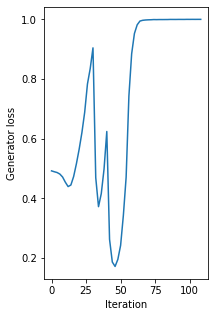

In [ ]:
gen_mnist = GeneratorMNIST(100).to(device)
discr_mnist = DiscriminatorMNIST().to(device)
prior_mnist = torch.distributions.Normal(torch.zeros(100).cuda(), torch.ones(100).to(device))

gen_opt_mnist = optim.Adam(gen_mnist.parameters(), lr=3e-4)
discr_opt_mnist = optim.Adam(discr_mnist.parameters(), lr=3e-4, betas=(0.5, 0.999))

train_gan(trainloader_mnist, gen_mnist, 
          discr_mnist, gen_opt_mnist, discr_opt_mnist, prior_mnist,
          num_epochs=20, gen_steps=1, discr_steps=1,
          verbose_num_iters=10, data_type='mnist')

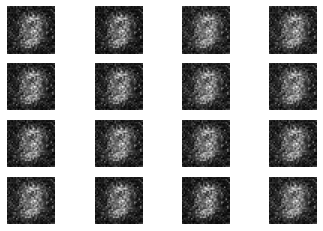

In [ ]:
z = prior_mnist.sample((16, ))

sampled_mnist = gen_mnist(z)

for i in range(16):
  plt.subplot(4, 4, i + 1)
  plt.axis('off')
  plt.imshow(sampled_mnist[i, 0].detach().cpu().numpy(), cmap='gray')

Для полного обучения Vanilla GAN на MNIST требуется довольно много времени (более 200 эпох), но уже после 20 эпох сгенерированные картинки становятся похожими на реальные объекты, хоть и немного шумными.

## 3. WGAN.

Проблема долгого и нестабильного обучения Vanilla GAN кроется в том функционале (и соответсвенно ограничении на выход дискриминатора), который он оптимизирует - когда значения дискриминатора близки к $0$ и $1$, градиент через сигмоиду дискриминатора идет довольно малый.

Благо, как оказалось, мы можем поменять функционал и вместо логаритма от сигмоиды использовать другой, более удобный для оптимизации.

Авторы WGAN предложили оптимизировать следующую функцию и убрать ограничение на выход дискриминатора:

$L(D, G) = - \frac1n \sum_{x_i \in X} D(x_i) + \frac1n \sum_{z_i \in N(0, 1)} D(G(z_i)) \rightarrow \min_{D} \max_{G}$

Однако, цена такого подхода - в необходимости поддерживать константу Липшица у дискриминатора. Самый простой способ это сделать - производить клиппинг (обрезка снизу и сверху) весов дискриминатора.

In [ ]:
class GeneratorMNISTWGAN(nn.Module):
  def __init__(self, lat_size, hidden=64):
    super(GeneratorMNISTWGAN, self).__init__()
    self.lat_size = lat_size
        # Filters [1024, 512, 256]
        # Input_dim = 100
        # Output_dim = C = 1 (number of channels)

    self.net = nn.Sequential(
        nn.ConvTranspose2d(in_channels=lat_size + 1, out_channels=256, kernel_size=4, stride=1, padding=0),
        nn.BatchNorm2d(num_features=256),
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(num_features=128),
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
        nn.BatchNorm2d(num_features=64),
        nn.ReLU(),

        nn.ConvTranspose2d(in_channels=64, out_channels=1, kernel_size=4, stride=2, padding=1),
        nn.Tanh())
    
  # output of main module --> Image (1x32x32)
  def forward(self, x, y):
    y = y.view(y.shape[0], 1)
    xy = torch.cat((x, y), dim=1)        
    xy = xy.view(xy.shape[0], xy.shape[1], 1, 1)
    return self.net(xy)


class DiscriminatorMNISTWGAN(nn.Module):
  def __init__(self, hidden=32):
    super(DiscriminatorMNISTWGAN, self).__init__()

    self.net = nn.Sequential(
        # Image (Cx32x32)
        nn.Conv2d(in_channels=2, out_channels=64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2),

        nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2),

        nn.Conv2d(in_channels=128, out_channels=256, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2),

        nn.Conv2d(in_channels=256, out_channels=1, kernel_size=4, stride=1, padding=0, bias=False)
    )


  def forward(self, x, y):
    # клиппинг весов
    for p in self.parameters():
      p.data.clamp_(-0.01, 0.01)
    label_channels = torch.ones(x.shape).to(device)
    for i, label in enumerate(y):
        label_channels[i] *= label
    xy = torch.cat((x, label_channels), dim=1)
    #return self.net(x).view(-1, 1)
    return self.net(xy).view(-1, 1)

In [ ]:
def train_gan(tr_dataloader,
              gen, discr, 
              gen_opt, discr_opt, prior, 
              num_epochs, gen_steps, discr_steps,
              discr_params_clip_value=None,
              verbose_num_iters=100,
              data_type='2d'):
    '''
    Имплементирует подсчет лосса для генератора и дискриминатора.
    '''
    #gen.train()
    #discr.train()
    gen_loss_trace = []
    discr_loss_trace = []

    iter_i = 0

    for epoch_i in range(num_epochs):        
        print(f'Epoch {epoch_i + 1}')
        for batch in tr_dataloader:
            # батч реальных объектов
            real_samples, y = batch
            y = y.to(device)
            real_samples = real_samples.to(device)
            batch_size = real_samples.shape[0]

            # таргеты реальных объектов (1) и сгенерированных (0)
            real_samples_labels = torch.ones((batch_size, 1)).to(device)
            gen_samples_labels = torch.zeros((batch_size, 1)).to(device)
            lat_samples_codes = prior.sample((batch_size, ))

            # батч сгенерированных объектов
            gen_samples = gen(lat_samples_codes, y)

            # двойной батч на вход дискриминатору и его реальные таргеты (1 и 0)
            all_samples = torch.cat((real_samples, gen_samples), dim=0)
            all_samples_labels = torch.cat((real_samples_labels, gen_samples_labels), dim=0)

            # выходы дискриминатора на двойном батче
            all_samples_output = discr(all_samples, torch.cat((y, y), dim=0))
            real_samples_output, gen_samples_output = torch.split(all_samples_output, batch_size)

            if (iter_i % (gen_steps + discr_steps)) < gen_steps:
                # генератор учится на gen_samples_output и считает ошибку по real_samples_labels
                gen_opt.zero_grad()
                gen_loss = gen_samples_output.mean(0).view(1)
                gen_loss.backward()
                gen_opt.step()
                gen_loss_trace.append((iter_i, gen_loss.item()))
            else:
                # дискриминатор учится на all_samples и считает ошибку по all_samples_labels = real_samples_labels + generated_samples_labels
                discr_opt.zero_grad()
                discr_loss = (real_samples_output - gen_samples_output).mean(0).view(1)
                discr_loss.backward()
                discr_opt.step()
                discr_loss_trace.append((iter_i, discr_loss.item()))
        
            iter_i += 1
         # Выводим значения функций потерь
            if iter_i % verbose_num_iters == 0:
                clear_output(wait=True)
                plt.figure(figsize=(10, 5))
                
                plt.subplot(1, 3, 1)
                plt.xlabel('Iteration')
                plt.ylabel('Generator loss')
                plt.plot([p[0] for p in gen_loss_trace], 
                         [p[1] for p in gen_loss_trace])

                plt.subplot(1, 3, 2)
                plt.xlabel('Iteration')
                plt.ylabel('Discriminator loss')
                plt.plot([p[0] for p in discr_loss_trace], 
                         [p[1] for p in discr_loss_trace], color='orange')
                    
                with torch.no_grad():
                    z = prior.sample((batch_size, ))
                    sampled_mnist = gen(z, y)

                for i in range(16):
                    plt.subplot(4, 12, 12 * (i // 4) + 9 + (i % 4))
                    plt.axis('off')
                    plt.imshow(sampled_mnist[i].detach().cpu().reshape(32, 32), cmap="gray_r")

                plt.show()

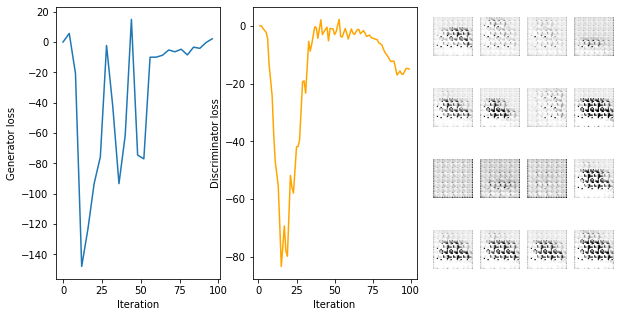

KeyboardInterrupt: ignored

In [ ]:
gen_mnist = GeneratorMNISTWGAN(100).to(device)
discr_mnist = DiscriminatorMNISTWGAN().to(device)
prior_mnist = torch.distributions.Normal(torch.zeros(100).cuda(), torch.ones(100).to(device))

gen_opt_mnist = optim.RMSprop(gen_mnist.parameters(), lr=3e-4)
discr_opt_mnist = optim.RMSprop(discr_mnist.parameters(), lr=3e-4) 

train_gan(trainloader_mnist, gen_mnist, 
          discr_mnist, gen_opt_mnist, discr_opt_mnist, prior_mnist,
          num_epochs=50, gen_steps=1, discr_steps=3,
          verbose_num_iters=100, data_type='mnist')

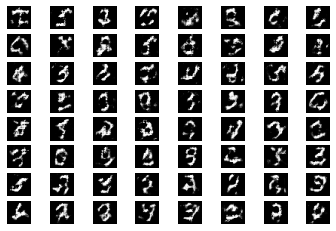

In [ ]:
z = prior_mnist.sample((64, ))
labels = torch.ones(64).to(device)

sampled_mnist = gen_mnist(z, labels)

for i in range(64):
  plt.subplot(8, 8, i + 1)
  plt.axis('off')
  plt.imshow(sampled_mnist[i, 0].detach().cpu().numpy(), cmap='gray')

Как и в случае с обычным GAN, ждать полного схождения обучения довольно долго, хотя ускорение и стабильность видна невооруженным глазом. Приятные глазу результаты достигаются уже через 80 эпох.

## 4. Conditional GAN. 

GAN очень просто может быть изменен для conditional случая - когда мы хотим генерировать изображения из определенного класса.

Для этого в дискриминатор и генератор вместе с изображением и латентным кодом, соответственно, надо передавать метку класса (или св-ва объекта).

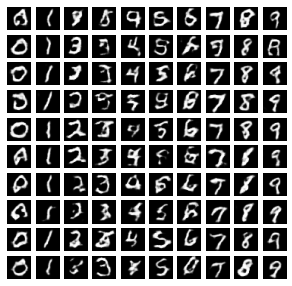

In [ ]:
z = prior_mnist_cond.sample((100, ))

y = torch.arange(100).cuda() % 10
sampled_mnist_cond = gen_mnist_cond(z, y)

plt.figure(figsize=(5, 5))

for i in range(100):
  plt.subplot(10, 10, i + 1)
  plt.axis('off')
  plt.imshow(sampled_mnist_cond[i, 0].detach().cpu().numpy(), cmap='gray')

## 5. Применения.

### 5.1 Восстановление латентного кода объекта.

В отличие от VAE, у нас нет маппинга объектов на латентные коды. 

Если вам необходимо поработать с латентным кодом объекта, его сначала надо восстановить. Сделать это можно через градиентный спуск.

In [ ]:
for x, _ in trainloader_mnist:
  break

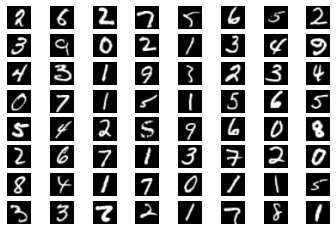

In [ ]:
for i in range(64):
  plt.subplot(8, 8, i + 1)
  plt.axis('off')
  plt.imshow(x[i, 0].detach().cpu().numpy(), cmap='gray')

In [ ]:
z = prior_mnist.sample((64, )).requires_grad_()
z.cuda()
x.cuda()
1;

In [ ]:
# считаем MSE между восстановленными объектами и настоящими и делаем шаг по градиенту z
for i in range(20000):
  loss = nn.MSELoss()(gen_mnist(z), x.cuda())
  loss.backward()
  z.data.add_(-0.5 * z.grad.data)
  z.grad.zero_()

  if i % 1000 == 0:
    print(loss.item())

0.4306119680404663
0.32233306765556335
0.265311062335968
0.2276405245065689
0.20071814954280853
0.18118630349636078
0.1634572595357895
0.1501706838607788
0.1376849114894867
0.12837839126586914
0.11870875954627991
0.11020404100418091
0.10345998406410217
0.09744429588317871
0.09280575066804886
0.08805719763040543
0.08326639980077744
0.07973331212997437
0.07666362822055817
0.0738384872674942


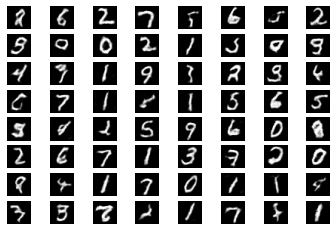

In [ ]:
rec_x = gen_mnist(z)

for i in range(64):
  plt.subplot(8, 8, i + 1)
  plt.axis('off')
  plt.imshow(rec_x[i, 0].detach().cpu().numpy(), cmap='gray')

### 5.2 Нужно ли выкидывать дискриминатор при генерации?

Важным моментом работы с GAN'ами является и то, что засемпленные объекты можно ещё улучшить, сделав несколько шагов по градиенту от дискриминатора.

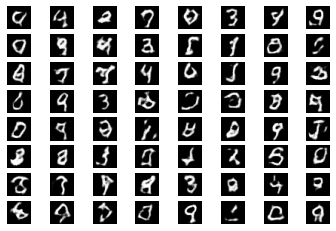

In [ ]:
z = prior_mnist.sample((64, )).requires_grad_()

gen_imgs = gen_mnist(z.cuda())
for i in range(64):
  plt.subplot(8, 8, i + 1)
  plt.axis('off')
  plt.imshow(gen_imgs[i, 0].detach().cpu().numpy(), cmap='gray')


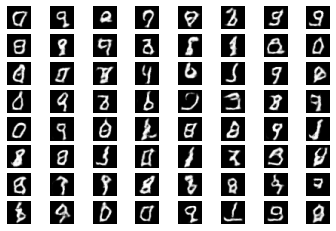

In [ ]:
# считаем градиент от дискриминатора и делаем шаг по градиенту z
for i in range(2000):
  loss = discr_mnist(gen_mnist(z.cuda())).mean()
  loss.backward()
  z.data.add_(z.grad.data)
  z.grad.zero_()

gen_imgs = gen_mnist(z.cuda())
for i in range(64):
  plt.subplot(8, 8, i + 1)
  plt.axis('off')
  plt.imshow(gen_imgs[i, 0].detach().cpu().numpy(), cmap='gray')